In [1]:
import torch as t 
from torch import nn

In [2]:
import sys
sys.path.append('/root/persistence_data')

In [1]:
import sys
sys.path.append('/root/persistence_data')
import _setup
# Config
from TechfinTorchAPI.config import *
from logger import get_logger
from TechfinDataAPI.utils.reader import pkl_reader
# Data
from TechfinTorchAPI.dataloader.pandas_dataloader import PandasDataset
from TechfinTorchAPI.dataloader.tensor_dataset import TensorListDataset
from TechfinDataAPI.pandas_methods.extraction import random_sample
# Training Structure
from TechfinTorchAPI.engine.hooks import *
from TechfinTorchAPI.engine.trainer import SimpleTrainer
# Losses
from TechfinTorchAPI.models import *
from TechfinTorchAPI.components.loss import *
# eval
from TechfinTorchAPI.matrics.pandas_matrics import my_IC, my_IR
from TechfinTorchAPI.engine.BT_system import BTSystem
from TechfinDataAPI.utils.decorator import time_consumption


#####################################
#       Hyperparameters
#####################################
eval_period = 500
test_batch_size = 30
result_path = '*'
_hidden_size = 64
_device = 'cuda'
iter_num = 5000
_optimizer = 'adam'
_num_layer = 1
learning_rate = 0.0001
training_batch_size = 500
_loss_func = '*'
checkpoint_freq = eval_period

#####################################
#       DataLoading for Training
#####################################
train_data = t.load('*')
test_data = t.load('*')
train_dataset = TensorListDataset(train_data, lambda x: (x[:,:-2].type(t.float32), x[:,-1].type(t.float32))).to(_device)
test_dataset = TensorListDataset(test_data, lambda x: (x[:,:-2].type(t.float32), x[:,-1].type(t.float32))).to(_device)

train_loader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=training_batch_size, shuffle = False)


#####################################
#       DataLoading for Evaluation
#####################################
logger = get_logger(__name__)
train_data_ = pkl_reader('*')
test_data_ = pkl_reader('*')
logger.info('Data reading finishes')
train_dataset_ = PandasDataset(train_data_, 
                              None, # 需要被截面标准化的cols
                              lambda x: (x.iloc[:,:-2], x.iloc[:,-1])) #输出前的transform_method。只输出因子还有label_2
test_dataset_ = PandasDataset(test_data_,
                            None,
                            lambda x: (x.iloc[:,:-2], x.iloc[:,-1])) 


2021-10-27 10:03:24,782 - [<module>] - INFO: Data reading finishes


In [2]:
len(train_data), len(test_data)

(1544857, 369565)

# 模型加载

In [15]:
from TechfinTorchAPI.utils.experiment_loading import best_model_laoding

In [16]:
model_RankMse_result = best_model_laoding('*')
model_Pearson_result = best_model_laoding('*')

In [17]:
model_RankMse = model_RankMse_result['model'].to('cuda')
model_Pearson = model_Pearson_result['model'].to('cuda')

# 回测系统搭建

In [69]:
    back_testing_sys = BTSystem(test_dataset_)
    back_testing_sys.register({'label_1_IR': my_IR('prediction', 'label_1'),
                               'label_2_IR': my_IR('prediction', 'label_2'),
                               'label_1_IC': my_IC('prediction', 'label_2'),
                               'label_2_IC': my_IC('prediction', 'label_1')})

In [78]:
res  =back_testing_sys(model)

2021-10-26 18:56:14,458 - [__call__] - DEBUG: An error happens in the label_1_IR evaluation
2021-10-26 18:56:14,617 - [__call__] - DEBUG: An error happens in the label_2_IR evaluation
2021-10-26 18:56:14,773 - [__call__] - DEBUG: An error happens in the label_1_IC evaluation
2021-10-26 18:56:14,928 - [__call__] - DEBUG: An error happens in the label_2_IC evaluation


In [13]:
result_pearson = back_testing_sys(model_Pearson)

In [14]:
result = back_testing_sys(model_RankMse)

In [15]:
import matplotlib.pyplot as plt

In [18]:
IC1 = result['label_1_IC']
IC_P = result_pearson['label_1_IC']

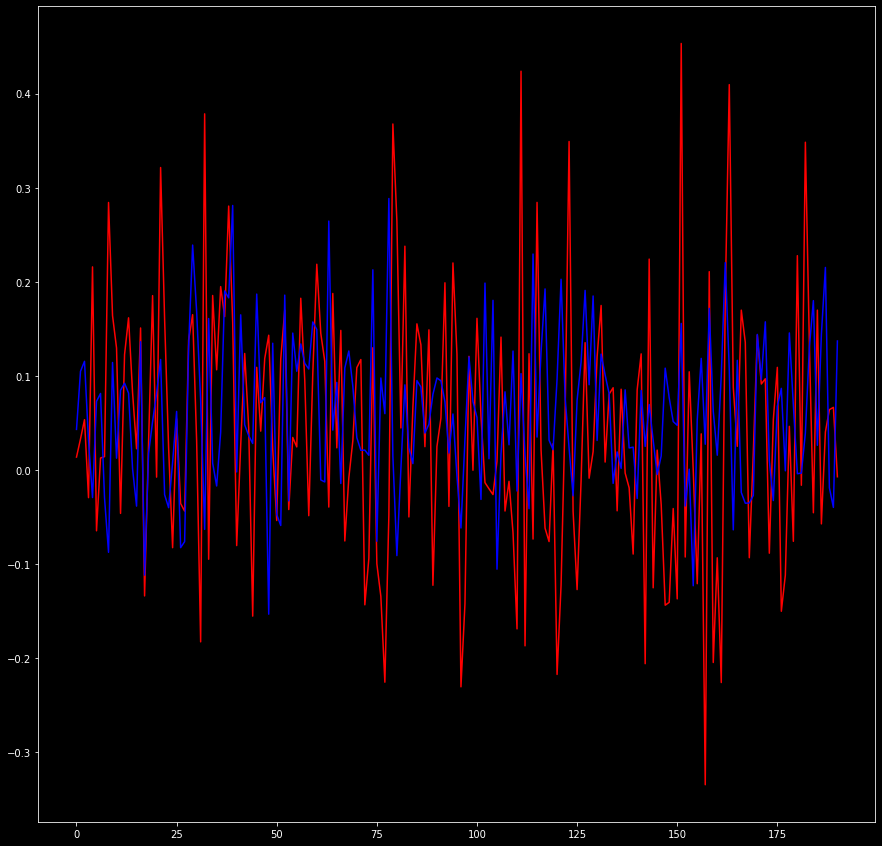

In [20]:
plt.figure(figsize = (15,15))
plt.plot(IC1, 'red')
plt.plot(IC_P,'blue')
# plt.plot(IC_R0,'green')